In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import datetime
from copy import deepcopy

# 一、数据准备

## 1.1 读取日度行情表

表内字段就是 Backtrader 默认情况下要求输入的 7 个字段： 'datetime' 、'open'、'high'、'low'、'close'、'volume'、'openinterest'，外加一个 'sec_code' 股票代码字段。

In [3]:
daily_price = pd.read_csv("./data/daily_price.csv", parse_dates=['datetime'])
daily_price

,datetime,sec_code,open,high,low,close,volume,openinterest
0,2019-01-02,600466.SH,33.064891,33.496709,31.954503,32.386321,10629352,0
1,2019-01-02,603228.SH,50.660230,51.458513,50.394136,51.120778,426147,0
2,2019-01-02,600315.SH,148.258423,150.480132,148.258423,149.558935,2138556,0
3,2019-01-02,000750.SZ,49.512579,53.154883,48.715825,51.561375,227557612,0
4,2019-01-02,002588.SZ,36.608672,36.608672,35.669988,35.763857,2841517,0
...,...,...,...,...,...,...,...,...
255967,2021-01-28,600717.SH,121.489201,122.011736,120.705400,120.966667,6022213,0
255968,2021-01-28,300558.SZ,134.155888,137.600704,130.700970,131.569750,5330301,0
255969,2021-01-28,600171.SH,39.774873,39.830040,38.864630,38.947380,12354183,0
255970,2021-01-28,600597.SH,47.190201,49.243025,46.250355,46.423484,32409940,0


In [4]:
daily_price.query("sec_code=='600466.SH'")

,datetime,sec_code,open,high,low,close,volume,openinterest
0,2019-01-02,600466.SH,33.064891,33.496709,31.954503,32.386321,10629352,0
546,2019-01-03,600466.SH,32.262944,32.941515,31.399309,31.831127,8602646,0
1211,2019-01-04,600466.SH,31.399309,33.558397,31.337621,33.496709,12768116,0
1700,2019-01-07,600466.SH,33.496709,34.360344,33.373332,33.620085,10584321,0
2136,2019-01-08,600466.SH,33.311644,34.113591,32.694762,33.743462,10012902,0
...,...,...,...,...,...,...,...,...
253953,2021-01-22,600466.SH,30.245430,30.312942,29.502796,29.772845,17184055,0
253973,2021-01-25,600466.SH,29.570309,29.570309,28.827675,28.962699,23646174,0
254574,2021-01-26,600466.SH,28.962699,29.232748,28.692651,28.760163,9963442,0
255079,2021-01-27,600466.SH,28.760163,29.232748,28.692651,28.895187,12929331,0


In [5]:
# 以 datetime 为 index，类型为 datetime 或 date 类型，Datafeeds 默认情况下是将 index 匹配给 datetime 字段；
daily_price = daily_price.set_index(['datetime'])

## 1.2 读取调仓信息表

表内数据说明：

+ trade_date： 调仓期（每月最后一个交易日）;

+ sec_code：持仓成分股；

+ weight：持仓权重。

In [6]:
trade_info = pd.read_csv("./data/trade_info.csv", parse_dates=['trade_date'])
trade_info

,trade_date,sec_code,weight
0,2019-01-31,000006.SZ,0.007282
1,2019-01-31,000008.SZ,0.009783
2,2019-01-31,000025.SZ,0.006928
3,2019-01-31,000090.SZ,0.007234
4,2019-01-31,000536.SZ,0.003536
...,...,...,...
2490,2021-01-28,603712.SH,0.007630
2491,2021-01-28,603737.SH,0.019291
2492,2021-01-28,603816.SH,0.022646
2493,2021-01-28,603866.SH,0.018611


# 二、 选股回测

 选股策略：定期按持仓权重调仓 。

In [7]:
# 回测策略
class TestStrategy(bt.Strategy):
    params = (
        ('buy_stocks', None), # 传入各个调仓日的股票列表和相应的权重
    )
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('{}, {}'.format(dt.isoformat(), txt))

    def __init__(self):
         # 读取调仓日期，即每月的最后一个交易日，回测时，会在这一天下单，然后在下一个交易日，以开盘价买入
        self.trade_dates = pd.to_datetime(self.p.buy_stocks['trade_date'].unique()).tolist()
        self.buy_stock = self.p.buy_stocks # 保留调仓信息
        self.order_list = []  # 记录以往订单，在调仓日要全部取消未成交的订单
        self.buy_stocks_pre = [] # 记录上一期持仓
    
    def next(self):
        # 获取当前的回测时间点
        dt = self.datas[0].datetime.date(0)
        # 打印当前时刻的总资产
        self.log('当前总资产 %.2f' %(self.broker.getvalue()))
        # 如果是调仓日，则进行调仓操作
        if dt in self.trade_dates:
            print("--------------{} 为调仓日----------".format(dt))
            #取消之前所下的没成交也未到期的订单
            if len(self.order_list) > 0:
                print("--------------- 撤销未完成的订单 -----------------")
                for od in self.order_list:
                    # 如果订单未完成，则撤销订单
                    self.cancel(od) 
                 #重置订单列表
                self.order_list = [] 
                
            # 提取当前调仓日的持仓列表
            buy_stocks_data = self.buy_stock.query(f"trade_date=='{dt}'")
            long_list = buy_stocks_data['sec_code'].tolist()
            print('long_list', long_list)  # 打印持仓列表
            
            # 对现有持仓中，调仓后不再继续持有的股票进行卖出平仓
            sell_stock = [i for i in self.buy_stocks_pre if i not in long_list]
            print('sell_stock', sell_stock)
            if len(sell_stock) > 0:
                print("-----------对不再持有的股票进行平仓--------------")
                for stock in sell_stock:
                    data = self.getdatabyname(stock)
                    if self.getposition(data).size > 0 :
                        od = self.close(data=data)  
                        self.order_list.append(od) # 记录卖出订单

            # 买入此次调仓的股票：多退少补原则
            print("-----------买入此次调仓期的股票--------------")
            for stock in long_list:
                w = buy_stocks_data.query(f"sec_code=='{stock}'")['weight'].iloc[0] # 提取持仓权重
                data = self.getdatabyname(stock)
                order = self.order_target_percent(data=data, target=w*0.95) # 为减少可用资金不足的情况，留 5% 的现金做备用
                self.order_list.append(order)
                
            self.buy_stocks_pre = long_list  # 保存此次调仓的股票列表
        
    #订单日志    
    def notify_order(self, order):
        # 未被处理的订单
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 已被处理的订单
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s' %
                    (order.ref,
                     order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.size,
                     order.data._name))
            else:  # Sell
                self.log('SELL EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s' %
                        (order.ref,
                         order.executed.price,
                         order.executed.value,
                         order.executed.comm,
                         order.executed.size,
                         order.data._name))

In [8]:
# 实例化大脑
cerebro_ = bt.Cerebro() 

# 按股票代码，依次循环传入数据
for stock in daily_price['sec_code'].unique():
    # 日期对齐
    data = pd.DataFrame(index=daily_price.index.unique())
    df = daily_price.query(f"sec_code=='{stock}'")[['open','high','low','close','volume','openinterest']]
    data_ = pd.merge(data, df, left_index=True, right_index=True, how='left')
    data_.loc[:,['volume','openinterest']] = data_.loc[:,['volume','openinterest']].fillna(0)
    data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(method='pad')
    data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(0)
    datafeed = bt.feeds.PandasData(dataname=data_, fromdate=datetime.datetime(2019,1,2), todate=datetime.datetime(2021,1,28))
    cerebro_.adddata(datafeed, name=stock)
    print(f"{stock} Done !") 

600466.SH Done !
603228.SH Done !
600315.SH Done !
000750.SZ Done !
002588.SZ Done !
002926.SZ Done !
603816.SH Done !
002517.SZ Done !
600366.SH Done !
001914.SZ Done !
000732.SZ Done !
600733.SH Done !
000930.SZ Done !
002093.SZ Done !
603056.SH Done !
002078.SZ Done !
600978.SH Done !
600329.SH Done !
601872.SH Done !
600058.SH Done !
601019.SH Done !
600497.SH Done !
002563.SZ Done !
600699.SH Done !
601608.SH Done !
002051.SZ Done !
002603.SZ Done !
000636.SZ Done !
000980.SZ Done !
002217.SZ Done !
600291.SH Done !
600827.SH Done !
603369.SH Done !
000829.SZ Done !
002317.SZ Done !
002509.SZ Done !
002557.SZ Done !
002212.SZ Done !
000415.SZ Done !
000860.SZ Done !
600317.SH Done !
600060.SH Done !
600500.SH Done !
300474.SZ Done !
600273.SH Done !
000681.SZ Done !
603707.SH Done !
600967.SH Done !
600415.SH Done !
002056.SZ Done !
600267.SH Done !
600161.SH Done !
002670.SZ Done !
002127.SZ Done !
002815.SZ Done !
002223.SZ Done !
002690.SZ Done !
600039.SH Done !
600126.SH Done

# 三、添加分析器

In [65]:
cerebro = deepcopy(cerebro_)  # 深度复制已经导入数据的 cerebro_，避免重复导入数据 
# 初始资金 100,000,000    
cerebro.broker.setcash(100000000.0) 
# 添加策略
cerebro.addstrategy(TestStrategy, buy_stocks=trade_info) # 通过修改参数 buy_stocks ，使用同一策略回测不同的持仓列表

# 添加分析指标
# 返回年初至年末的年度收益率
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='_AnnualReturn')
# 计算最大回撤相关指标
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown')
# 计算年化收益
cerebro.addanalyzer(bt.analyzers.Returns, _name='_Returns', tann=252)
# 计算年化夏普比率
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_SharpeRatio', timeframe=bt.TimeFrame.Days, annualize=True, riskfreerate=0) # 计算夏普比率
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='_SharpeRatio_A')
# 返回收益率时序
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')

# 启动回测
result = cerebro.run()

2019-01-02, 当前总资产 100000000.00
2019-01-03, 当前总资产 100000000.00
2019-01-04, 当前总资产 100000000.00
2019-01-07, 当前总资产 100000000.00
2019-01-08, 当前总资产 100000000.00
2019-01-09, 当前总资产 100000000.00
2019-01-10, 当前总资产 100000000.00
2019-01-11, 当前总资产 100000000.00
2019-01-14, 当前总资产 100000000.00
2019-01-15, 当前总资产 100000000.00
2019-01-16, 当前总资产 100000000.00
2019-01-17, 当前总资产 100000000.00
2019-01-18, 当前总资产 100000000.00
2019-01-21, 当前总资产 100000000.00
2019-01-22, 当前总资产 100000000.00
2019-01-23, 当前总资产 100000000.00
2019-01-24, 当前总资产 100000000.00
2019-01-25, 当前总资产 100000000.00
2019-01-28, 当前总资产 100000000.00
2019-01-29, 当前总资产 100000000.00
2019-01-30, 当前总资产 100000000.00
2019-01-31, 当前总资产 100000000.00
--------------2019-01-31 为调仓日----------
long_list ['000006.SZ', '000008.SZ', '000025.SZ', '000090.SZ', '000536.SZ', '000587.SZ', '000598.SZ', '000612.SZ', '000636.SZ', '000656.SZ', '000690.SZ', '000712.SZ', '000766.SZ', '000807.SZ', '000829.SZ', '000877.SZ', '000980.SZ', '000999.SZ', '002002.SZ', '002048.SZ', '002051

In [71]:
strat = result[0]
print("--------------- AnnualReturn -----------------")
print(strat.analyzers._AnnualReturn.get_analysis())
print("--------------- DrawDown -----------------")
print(strat.analyzers._DrawDown.get_analysis())
print("--------------- Returns -----------------")
print(strat.analyzers._Returns.get_analysis())
print("--------------- SharpeRatio -----------------")
print(strat.analyzers._SharpeRatio.get_analysis())
print("--------------- SharpeRatio_A -----------------")
print(strat.analyzers._SharpeRatio_A.get_analysis())

--------------- AnnualReturn -----------------
OrderedDict([(2019, 0.24595939208613182), (2020, 0.21926556497165728), (2021, 0.017796842102610233)])
--------------- DrawDown -----------------
AutoOrderedDict([('len', 136), ('drawdown', 6.485331961234954), ('moneydown', 10722986.769377261), ('max', AutoOrderedDict([('len', 206), ('drawdown', 20.276455833295294), ('moneydown', 27595022.636924908)]))])
--------------- Returns -----------------
OrderedDict([('rtot', 0.43579484325900286), ('ravg', 0.0008612546309466459), ('rnorm', 0.24238903480764556), ('rnorm100', 24.238903480764556)])
--------------- SharpeRatio -----------------
OrderedDict([('sharperatio', 1.0404643450411675)])
--------------- SharpeRatio_A -----------------
OrderedDict([('sharperatio', 1.482647300482646)])


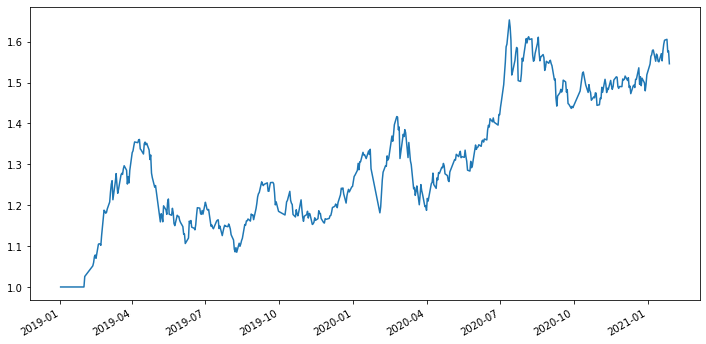

In [77]:
# 绘制累计收益率
ret = pd.Series(strat.analyzers._TimeReturn.get_analysis())
(ret + 1).cumprod().plot(figsize=(12,6))

# 四、自定义分析器

In [82]:
class trade_list(bt.Analyzer):

    def __init__(self):

        self.trades = []
        self.cumprofit = 0.0

    def notify_trade(self, trade):

        if trade.isclosed:

            brokervalue = self.strategy.broker.getvalue()

            dir = 'short'
            if trade.history[0].event.size > 0: dir = 'long'

            pricein = trade.history[len(trade.history)-1].status.price
            priceout = trade.history[len(trade.history)-1].event.price
            datein = bt.num2date(trade.history[0].status.dt)
            dateout = bt.num2date(trade.history[len(trade.history)-1].status.dt)
            if trade.data._timeframe >= bt.TimeFrame.Days:
                datein = datein.date()
                dateout = dateout.date()

            pcntchange = 100 * priceout / pricein - 100
            pnl = trade.history[len(trade.history)-1].status.pnlcomm
            pnlpcnt = 100 * pnl / brokervalue
            barlen = trade.history[len(trade.history)-1].status.barlen
            pbar = pnl / barlen
            self.cumprofit += pnl

            size = value = 0.0
            for record in trade.history:
                if abs(size) < abs(record.status.size):
                    size = record.status.size
                    value = record.status.value

            highest_in_trade = max(trade.data.high.get(ago=0, size=barlen+1))
            lowest_in_trade = min(trade.data.low.get(ago=0, size=barlen+1))
            hp = 100 * (highest_in_trade - pricein) / pricein
            lp = 100 * (lowest_in_trade - pricein) / pricein
            if dir == 'long':
                mfe = hp
                mae = lp
            if dir == 'short':
                mfe = -lp
                mae = -hp

            self.trades.append({'ref': trade.ref, 'ticker': trade.data._name, 'dir': dir,
                 'datein': datein, 'pricein': pricein, 'dateout': dateout, 'priceout': priceout,
                 'chng%': round(pcntchange, 2), 'pnl': pnl, 'pnl%': round(pnlpcnt, 2),
                 'size': size, 'value': value, 'cumpnl': self.cumprofit,
                 'nbars': barlen, 'pnl/bar': round(pbar, 2),
                 'mfe%': round(mfe, 2), 'mae%': round(mae, 2)})
            
    def get_analysis(self):
        return self.trades

In [85]:
cerebro = deepcopy(cerebro_)  # 深度复制已经导入数据的 cerebro_，避免重复导入数据 
# 初始资金 100,000,000    
cerebro.broker.setcash(100000000.0) 
# 添加策略
cerebro.addstrategy(TestStrategy, buy_stocks=trade_info) # 通过修改参数 buy_stocks ，使用同一策略回测不同的持仓列表

# 添加自定义的分析指标
cerebro.addanalyzer(trade_list, _name='tradelist')

# 启动回测
result = cerebro.run(tradehistory=True)

2019-01-02, 当前总资产 100000000.00
2019-01-03, 当前总资产 100000000.00
2019-01-04, 当前总资产 100000000.00
2019-01-07, 当前总资产 100000000.00
2019-01-08, 当前总资产 100000000.00
2019-01-09, 当前总资产 100000000.00
2019-01-10, 当前总资产 100000000.00
2019-01-11, 当前总资产 100000000.00
2019-01-14, 当前总资产 100000000.00
2019-01-15, 当前总资产 100000000.00
2019-01-16, 当前总资产 100000000.00
2019-01-17, 当前总资产 100000000.00
2019-01-18, 当前总资产 100000000.00
2019-01-21, 当前总资产 100000000.00
2019-01-22, 当前总资产 100000000.00
2019-01-23, 当前总资产 100000000.00
2019-01-24, 当前总资产 100000000.00
2019-01-25, 当前总资产 100000000.00
2019-01-28, 当前总资产 100000000.00
2019-01-29, 当前总资产 100000000.00
2019-01-30, 当前总资产 100000000.00
2019-01-31, 当前总资产 100000000.00
--------------2019-01-31 为调仓日----------
long_list ['000006.SZ', '000008.SZ', '000025.SZ', '000090.SZ', '000536.SZ', '000587.SZ', '000598.SZ', '000612.SZ', '000636.SZ', '000656.SZ', '000690.SZ', '000712.SZ', '000766.SZ', '000807.SZ', '000829.SZ', '000877.SZ', '000980.SZ', '000999.SZ', '002002.SZ', '002048.SZ', '002051

In [90]:
pd.DataFrame(result[0].analyzers.tradelist.get_analysis())

,ref,ticker,dir,datein,pricein,dateout,priceout,chng%,pnl,pnl%,size,value,cumpnl,nbars,pnl/bar,mfe%,mae%
0,6586,000612.SZ,long,2019-02-01,36.838173,2019-03-01,46.338544,25.79,116351.042167,0.10,12247,4.511571e+05,1.163510e+05,15,7756.74,29.74,0.00
1,6587,000636.SZ,long,2019-02-01,172.762500,2019-03-01,236.616875,36.96,329424.720625,0.28,5159,8.912817e+05,4.457758e+05,15,21961.65,52.94,0.00
2,6591,000766.SZ,long,2019-02-01,19.804062,2019-03-01,25.163577,27.06,93877.266141,0.08,17516,3.468879e+05,5.396530e+05,15,6258.48,30.20,-0.33
3,6592,000807.SZ,long,2019-02-01,23.945099,2019-03-01,31.359917,30.97,264345.664040,0.22,35651,8.536667e+05,8.039987e+05,15,17623.04,36.36,0.00
4,6593,000829.SZ,long,2019-02-01,69.728937,2019-03-01,90.499258,29.79,129939.131930,0.11,6256,4.362242e+05,9.339378e+05,15,8662.61,40.43,-0.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,7390,600959.SH,long,2020-11-02,4.809258,2021-01-04,4.495455,-6.52,-73971.303962,-0.05,235725,1.133662e+06,4.854122e+07,44,-1681.17,5.09,-7.94
798,7445,601717.SH,long,2020-12-01,23.003961,2021-01-04,25.823190,12.26,125700.963423,0.08,44587,1.025678e+06,4.866692e+07,23,5465.26,24.30,-4.33
799,7448,603198.SH,long,2020-12-01,36.751896,2021-01-04,41.230664,12.19,215057.006417,0.14,48017,1.764716e+06,4.888198e+07,23,9350.30,36.27,-5.69
800,7310,603659.SH,long,2020-08-03,105.138155,2021-01-04,116.205444,10.53,322492.512325,0.21,30301,3.185791e+06,4.920447e+07,103,3131.00,21.09,-11.13


# 五、参数优化

In [97]:
# 筛选 600466.SH 股票的数据集
data1 = daily_price.query(f"sec_code=='600466.SH'").drop(columns=['sec_code'])
data1

,open,high,low,close,volume,openinterest
datetime,,,,,,
2019-01-02,33.064891,33.496709,31.954503,32.386321,10629352,0
2019-01-03,32.262944,32.941515,31.399309,31.831127,8602646,0
2019-01-04,31.399309,33.558397,31.337621,33.496709,12768116,0
2019-01-07,33.496709,34.360344,33.373332,33.620085,10584321,0
2019-01-08,33.311644,34.113591,32.694762,33.743462,10012902,0
...,...,...,...,...,...,...
2021-01-22,30.245430,30.312942,29.502796,29.772845,17184055,0
2021-01-25,29.570309,29.570309,28.827675,28.962699,23646174,0
2021-01-26,28.962699,29.232748,28.692651,28.760163,9963442,0


In [107]:
class TestStrategy(bt.Strategy):
  
    params=(('period1',5),
            ('period2',10),)   #全局设定均线周期
    
    def __init__(self):
        #计算均线
        self.ma1 = bt.indicators.SMA(self.data0, period=self.p.period1)
        self.ma2 = bt.indicators.SMA(self.data0, period=self.p.period2)
        #计算2条均线交叉信号：ma2 上穿 ma1 时，取值为 +1； ma2 下穿 ma1 时，取值为 -1
        self.crossover = bt.indicators.CrossOver(self.ma2, self.ma1) 
        # 初始化订单
        self.order = None
        
    def next(self):
        
        # 取消之前未执行的订单
        if self.order:  
            self.cancel(self.order)  
        
        # 检查是否有持仓
        if not self.position:  
            # 10日均线上穿5日均线，买入
            if self.crossover > 0:             
                self.order = self.buy(size=100) # 以下一日开盘价买入100股
        # # 10日均线下穿5日均线，卖出
        elif self.crossover < 0:            
            self.order = self.close() # 平仓，以下一日开盘价卖出
    
                                   

# 实例化大脑
cerebro1= bt.Cerebro()
# 设置初始资金
cerebro1.broker.set_cash(10000000)
# 加载数据
datafeed1 = bt.feeds.PandasData(dataname=data1, fromdate=datetime.datetime(2019,1,2), todate=datetime.datetime(2021,1,28))
cerebro1.adddata(datafeed1, name='600466.SH')
# 添加优化器
cerebro1.optstrategy(TestStrategy, period1 = range(5, 25, 5), period2 = range(10, 41, 10))

# 添加分析指标
# 返回年初至年末的年度收益率
cerebro1.addanalyzer(bt.analyzers.AnnualReturn, _name='_AnnualReturn')
# 计算最大回撤相关指标
cerebro1.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown')
# 计算年化收益
cerebro1.addanalyzer(bt.analyzers.Returns, _name='_Returns', tann=252)
# 计算年化夏普比率
cerebro1.addanalyzer(bt.analyzers.SharpeRatio_A, _name='_SharpeRatio_A')
# 返回收益率时序
cerebro1.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')

# 启动回测
result = cerebro1.run()  

In [126]:
def get_my_analyzer(result):
    analyzer = {}
    # 返回参数
    analyzer['period1'] = result.params.period1
    analyzer['period2'] = result.params.period2
    # 提取年化收益
    analyzer['年化收益率'] = result.analyzers._Returns.get_analysis()['rnorm']
    analyzer['年化收益率（%）'] = result.analyzers._Returns.get_analysis()['rnorm100']
    # 提取最大回撤
    analyzer['最大回撤（%）'] = result.analyzers._DrawDown.get_analysis()['max']['drawdown'] * (-1)
    # 提取夏普比率
    analyzer['年化夏普比率'] = result.analyzers._SharpeRatio_A.get_analysis()['sharperatio']
    
    return analyzer

ret = []
for i in result:
    ret.append(get_my_analyzer(i[0]))
    
pd.DataFrame(ret).sort_values(by='年化收益率', ascending=False)

,period1,period2,年化收益率,年化收益率（%）,最大回撤（%）,年化夏普比率
0,5,10,4.024514e-05,4.024514e-03,-0.010175,-140.948647
11,15,40,1.708522e-05,1.708522e-03,-0.013492,-213.637841
5,10,20,8.568641e-06,8.568641e-04,-0.009392,-282.835125
15,20,40,6.699340e-06,6.699340e-04,-0.013492,-301.729232
6,10,30,1.835459e-06,1.835459e-04,-0.008545,-265.568666
4,10,10,0.000000e+00,0.000000e+00,-0.000000,NaN
13,20,20,0.000000e+00,0.000000e+00,-0.000000,NaN
8,15,10,-6.560915e-09,-6.560915e-07,-0.017579,-161.893285
1,5,20,-3.240455e-06,-3.240455e-04,-0.008839,-229.402157
7,10,40,-7.817367e-06,-7.817367e-04,-0.013492,-261.387903


In [127]:
pd.DataFrame(ret)

,period1,period2,年化收益率,年化收益率（%）,最大回撤（%）,年化夏普比率
0,5,10,4.024514e-05,4.024514e-03,-0.010175,-140.948647
1,5,20,-3.240455e-06,-3.240455e-04,-0.008839,-229.402157
2,5,30,-1.211110e-05,-1.211110e-03,-0.008674,-236.577612
3,5,40,-1.284502e-05,-1.284502e-03,-0.011886,-370.807650
4,10,10,0.000000e+00,0.000000e+00,-0.000000,NaN
5,10,20,8.568641e-06,8.568641e-04,-0.009392,-282.835125
6,10,30,1.835459e-06,1.835459e-04,-0.008545,-265.568666
7,10,40,-7.817367e-06,-7.817367e-04,-0.013492,-261.387903
8,15,10,-6.560915e-09,-6.560915e-07,-0.017579,-161.893285
9,15,20,-1.857955e-05,-1.857955e-03,-0.009652,-611.196458
